# Goal 
Build a ML model

## 1. download the data and load to pandas 

- prep: go to https://www.microsoft.com/en-us/research/project/mslr/ to download MSLR-WEB10K dataset and put it under data/MSLR-WEB10K

In [1]:
import os
import zipfile
import pandas as pd
from tqdm import tqdm
import numpy as np


ROOT_DIR = os.getcwd()
EXTRACT_DIR = os.path.join(ROOT_DIR, 'data', 'MSLR-WEB10K')
ZIP_FILEPATH = os.path.join(EXTRACT_DIR, "MSLR-WEB10K.zip")

# FOLD_FILE = os.path.join(EXTRACT_DIR, "MSLR-WEB10K", "Fold1", "train.txt")


def extract_zip(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

def parse_letor_file(file_path, n_features=136, sample = 2000):
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split('#')[0].split()
            label = int(parts[0])
            qid = int(parts[1].split(':')[1])
            features = [0.0] * n_features
            for item in parts[2:]:
                if ':' in item:
                    idx, val = item.split(':')
                    features[int(idx)-1] = float(val)
            data.append([label, qid] + features)
    
    columns = ['label', 'qid'] + [f'f{i+1}' for i in range(n_features)]
    df = pd.DataFrame(data, columns=columns)
    if sample != None:
        qids = np.random.choice(df.qid.unique(), sample, replace=False)

    return df[df.qid.isin(qids)].sort_values(by = 'qid')


# Step 1: Extract
fold1_path = os.path.join(EXTRACT_DIR, 'FOLD1')
if not os.path.exists(fold1_path ):
    extract_zip(ZIP_FILEPATH, EXTRACT_DIR)

# Step 2: Load Fold1 Test (Train is too big) into DataFrame
data_path = os.path.join(fold1_path, 'test.txt')
if os.path.exists(data_path):
    df = parse_letor_file(data_path)
    print(df.head())
else:
    print(f"Training file not found: {fold1_path}")


df.shape

     label  qid   f1   f2   f3   f4   f5   f6   f7   f8  ...  f127     f128  \
0        2   13  2.0  0.0  2.0  1.0  2.0  1.0  0.0  1.0  ...  35.0      1.0   
101      1   13  2.0  0.0  2.0  0.0  2.0  1.0  0.0  1.0  ...  35.0     60.0   
100      1   13  2.0  0.0  0.0  1.0  2.0  1.0  0.0  0.0  ...  52.0     14.0   
99       2   13  2.0  2.0  2.0  1.0  2.0  1.0  1.0  1.0  ...  34.0     26.0   
98       1   13  2.0  0.0  1.0  0.0  2.0  1.0  0.0  0.5  ...  23.0  85494.0   

     f129     f130     f131  f132  f133  f134  f135       f136  
0     0.0    266.0  25070.0  28.0   7.0   0.0   0.0   0.000000  
101   2.0  24260.0   7615.0   7.0  72.0   0.0   4.0  41.700000  
100  11.0    834.0  61229.0   5.0   4.0   0.0   3.0  14.000000  
99    8.0  18142.0   9943.0  10.0  64.0   0.0  38.0  43.238095  
98   16.0  63137.0  34790.0   2.0  31.0   0.0   0.0   0.000000  

[5 rows x 138 columns]


(241521, 138)

## 2. EDA

- y: imbalance

- x: feature type, process by each type

In [2]:
# y imbalance - keep all 3, 4, 2, 1 and 0 keep 5?
df_y_summary = df.groupby(['qid', 'label'])['label'].count().rename('n').reset_index()
df_y_summary = df_y_summary.pivot(index= 'qid', columns='label', values = 'n')
df_y_summary.median()

label
0    54.0
1    35.0
2    13.0
3     3.0
4     2.0
dtype: float64

In [3]:
x = [col for col in df if col.startswith('f')]

nuniques = df[x].nunique().rename('n').reset_index()
def bucketize(x):
    cat = None
    if x == 0:
        cat = 'all missing'
    elif x == 1:
        cat = 'constant'
    elif x == 2:
        cat = 'binary'
    elif 3<= x <= 10:
        cat = 'cat'
    else:
        cat = 'numerical'
    return cat

nuniques['type'] = nuniques['n'].apply(bucketize)
nuniques['type'].value_counts()

type
numerical    125
cat            6
binary         5
Name: count, dtype: int64

In [4]:
# binary
binary_x = nuniques.loc[nuniques.type == 'binary', 'index'].to_list()
for bx in binary_x:
    print(df[bx].value_counts())

f96
1.0    169541
0.0     71980
Name: count, dtype: int64
f97
0.0    225767
1.0     15754
Name: count, dtype: int64
f98
0.0    146226
1.0     95295
Name: count, dtype: int64
f99
0.0    193108
1.0     48413
Name: count, dtype: int64
f100
1.0    177939
0.0     63582
Name: count, dtype: int64


In [5]:
# categorical 
cat_x = nuniques.loc[nuniques.type == 'cat', 'index'].to_list()
for cx in cat_x:
    print(df[cx].value_counts(normalize = True).round(3))

def process_cat_research(x:pd.Series, thres = 0.01, prefix = None):
    val2perc = x.value_counts(normalize = True) 
    to_keep = val2perc[val2perc >= thres].index 
    df_processed = pd.get_dummies(x)[to_keep]
    if prefix:
        df_processed.columns = [prefix + '_' + str(int(colname)) for colname in df_processed]
    return df_processed

df_cat_x_processed = process_cat_research(df[cat_x[0]], prefix = cat_x[0])
for i in range(1, len(cat_x)):
    df_cat_x_processed = pd.concat([df_cat_x_processed, process_cat_research(df[cat_x[i]], prefix = cat_x[i])], axis = 1)

f1
2.0    0.330
1.0    0.282
3.0    0.178
0.0    0.121
4.0    0.061
5.0    0.019
6.0    0.006
7.0    0.001
9.0    0.001
8.0    0.000
Name: proportion, dtype: float64
f2
0.0    0.861
1.0    0.084
2.0    0.044
3.0    0.009
4.0    0.001
5.0    0.000
6.0    0.000
Name: proportion, dtype: float64
f3
1.0    0.341
0.0    0.310
2.0    0.255
3.0    0.079
4.0    0.013
5.0    0.002
6.0    0.001
7.0    0.000
9.0    0.000
8.0    0.000
Name: proportion, dtype: float64
f4
0.0    0.594
1.0    0.287
2.0    0.093
3.0    0.021
4.0    0.003
5.0    0.001
6.0    0.001
7.0    0.000
9.0    0.000
8.0    0.000
Name: proportion, dtype: float64
f5
2.0    0.338
1.0    0.302
3.0    0.182
0.0    0.089
4.0    0.061
5.0    0.019
6.0    0.006
7.0    0.001
9.0    0.001
8.0    0.000
Name: proportion, dtype: float64
f29
0.0    0.800
1.0    0.192
2.0    0.008
3.0    0.000
4.0    0.000
6.0    0.000
5.0    0.000
Name: proportion, dtype: float64


In [6]:
# numerical
num_x  = nuniques.loc[nuniques.type == 'numerical', 'index'].to_list()

means = df[num_x].mean()
stds = df[num_x].std()

df_num_x_processed = (df[num_x] - means) / stds

In [7]:
df_x_processed = pd.concat( [df[binary_x], df_num_x_processed, df_cat_x_processed], axis = 1)
df_x_processed.head(2)

,f96,f97,f98,f99,f100,f6,f7,f8,f9,f10,...,f4_2,f4_3,f5_2,f5_1,f5_3,f5_0,f5_4,f5_5,f29_0,f29_1
0,1.0,0.0,1.0,0.0,1.0,0.576777,-0.369509,1.080195,0.514428,0.527776,...,False,False,True,False,False,False,False,False,True,False
101,1.0,0.0,1.0,0.0,1.0,0.576777,-0.369509,1.080195,-0.733472,0.527776,...,False,False,True,False,False,False,False,False,True,False


## 3. model

In [8]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, XGBRanker
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

### 3.1 Binary Classification

In [9]:
df['label_binary'] = df['label'].apply(lambda x: 1 if x >= 2 else 0)
# df_new_y_summary = df.groupby(['qid', 'label_binary'])['label_binary'].count().rename('n').reset_index().pivot(index = 'qid', columns = 'label_binary', values = 'n')
# df_new_y_summary.mean()
print(df.label_binary.value_counts(normalize = True))
x_train, x_test, y_train, y_test = train_test_split(df_x_processed, df['label_binary'], test_size=0.2, random_state=12345)

label_binary
0    0.839182
1    0.160818
Name: proportion, dtype: float64


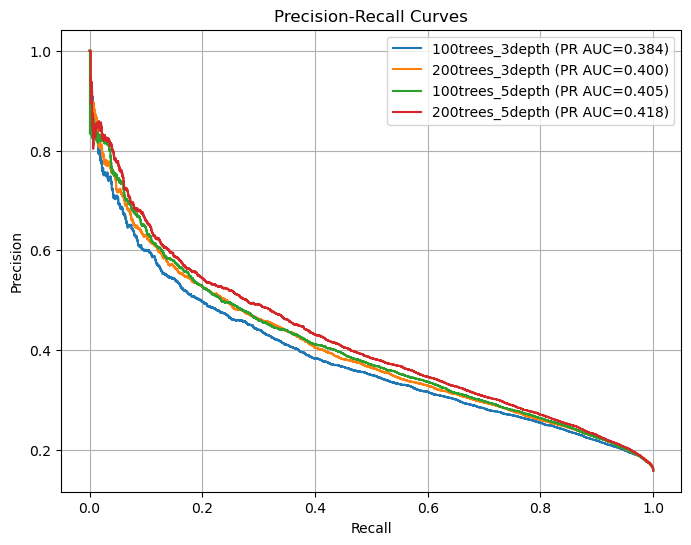

In [10]:
x_train, x_test, y_train, y_test = train_test_split(df_x_processed, df['label_binary'], test_size=0.2, random_state=12345)

def train_and_eval_binary_classifier(x_train, y_train, x_test, y_test, params = {}):

    trainer = XGBClassifier(**params)
    trainer.fit(x_train, y_train)

    y_test_proba = trainer.predict_proba(x_test)[:, 1]

    precision, recall, _ = precision_recall_curve(y_test, y_test_proba)

    pr_auc = auc(recall, precision)


    return trainer, precision, recall, pr_auc

def plot_multiple_pr_curves(name2prcurve):

    plt.figure(figsize=(8, 6))
    for name, (precision, recall, pr_auc) in name2prcurve.items():
        plt.plot(recall, precision, label=f'{name} (PR AUC={pr_auc:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

name2params = {'100trees_3depth': dict(random_state = 12345, n_estimators = 100, max_depth = 3),
               '200trees_3depth': dict(random_state = 12345, n_estimators = 200, max_depth = 3),
               '100trees_5depth': dict(random_state = 12345, n_estimators = 100, max_depth = 5),
               '200trees_5depth': dict(random_state = 12345, n_estimators = 200, max_depth = 5),
               }

name2trainers = {}
name2prcurve = {}
for name, params in name2params.items():
    trainer, precision, recall, pr_auc = train_and_eval_binary_classifier(x_train, y_train, x_test, y_test, params)
    name2trainers[name] = trainer
    name2prcurve[name] = (precision, recall, pr_auc)

plot_multiple_pr_curves(name2prcurve)


### 3.2 Learn to Rank
- TODO: understand lambdarank_pair_method 'mean' vs 'topk'

In [11]:
from pytrec_eval import RelevanceEvaluator

measures = ['ndcg_cut_10', 'ndcg_cut_20', 'ndcg_cut_30', 'ndcg_cut_40'] # 'recip_rank', 'P_1'}
def _eval_ranker(df_test, measures= measures):

    assert 'qid' in df_test, "df_test has to have qid"
    assert 'doc_id' in df_test, "df_test has to have doc_id"
    assert 'score' in df_test, "df_test has to have score"
    
    qrel, run = {}, {}
    for qid, group in df_test.groupby('qid'):
        qrel[str(qid)] = {str(doc_id): int(label) for doc_id, label in zip(df_test['doc_id'], df_test['label'])}
        run[str(qid)] = {str(doc_id): float(score) for doc_id, score in zip(df_test['doc_id'], df_test['score'])}

    evaluator =  RelevanceEvaluator(qrel, measures)
    results = evaluator.evaluate(run)

    mean_results = {measure: np.mean([val[measure] for val in results.values()]).item() for measure in measures} 

    return results, mean_results

def train_and_eval_learn2rank(df_train, df_test, x, y, params):

    group_train = df_train['qid'].value_counts(sort=False).values.tolist()


    ranker = XGBRanker(**params)
    ranker.fit(df_train[x], df_train[y], group = group_train)

    df_test['score'] = ranker.predict(df_test[x])

    results, mean_results = _eval_ranker(df_test)
    
    return trainer, results, mean_results

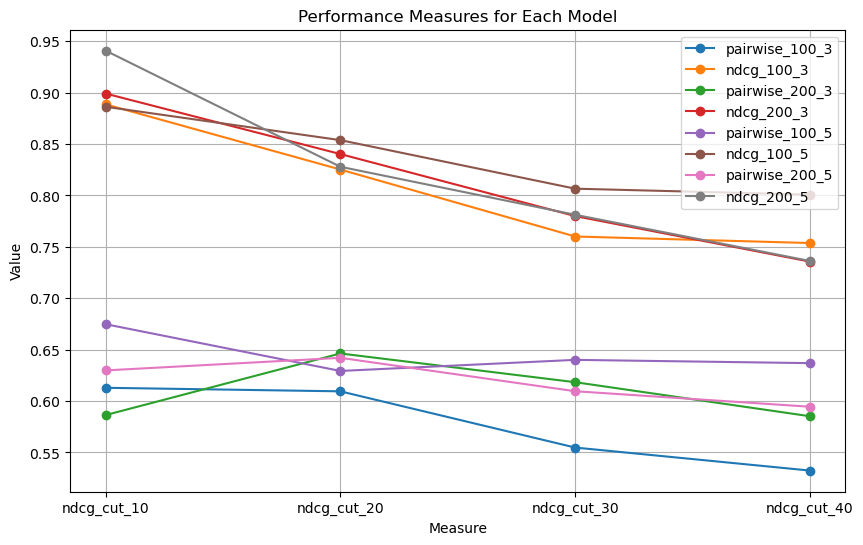

In [12]:
name2params = {'pairwise_100_3': dict(random_state =12345, objective = "rank:pairwise", n_estimators = 100, max_depth = 3),
                'ndcg_100_3':     dict(random_state =12345, objective = "rank:ndcg", n_estimators = 100, max_depth = 3),
                
                'pairwise_200_3': dict(random_state =12345, objective = "rank:pairwise", n_estimators = 200, max_depth = 3),
                'ndcg_200_3':     dict(random_state =12345, objective = "rank:ndcg", n_estimators = 200, max_depth = 3),

                'pairwise_100_5': dict(random_state =12345, objective = "rank:pairwise", n_estimators = 100, max_depth = 5),
                'ndcg_100_5':     dict(random_state =12345, objective = "rank:ndcg", n_estimators = 100, max_depth = 5),

                'pairwise_200_5': dict(random_state =12345, objective = "rank:pairwise", n_estimators = 200, max_depth = 5),
                'ndcg_200_5':     dict(random_state =12345, objective = "rank:ndcg", n_estimators = 200, max_depth = 5),
                }



# train test split
total_qid = df.qid.nunique()
n_qid_train = int(total_qid *0.8)

np.random.seed(12345)
qid_train = np.random.choice(df.qid.unique(), n_qid_train, replace = False)

df_processed = pd.concat([df_x_processed, df['label'], df['qid']], axis = 1)
df_processed_train = df_processed[df_processed.qid.isin(qid_train)].sort_values(by = 'qid')
df_processed_test = df_processed[~df_processed.qid.isin(qid_train)].sort_values(by = 'qid')
df_processed_test['doc_id'] = df_processed_test.index

x = df_x_processed.columns.to_list()
y = 'label'

# train and eval
name2trainers, name2perf = {}, {}

for name, params in name2params.items():

    trainer, results, mean_results = train_and_eval_learn2rank(df_processed_train,df_processed_test, x, y, params)
    name2trainers[name] = trainer 
    name2perf[name] = mean_results

measures = list(next(iter(name2perf.values())).keys())

plt.figure(figsize=(10, 6))
for name, perf in name2perf.items():
    values = [perf[m] for m in measures]
    plt.plot(measures, values, marker='o', label=name)

plt.xlabel('Measure')
plt.ylabel('Value')
plt.title('Performance Measures for Each Model')
plt.legend()
plt.grid(True)
plt.show()
